In [8]:
import sys
sys.path.append('PyTorch-VAE')
import os
import numpy as np
from pathlib import Path
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from models.hvae import HVAE
from models.lvae import LVAE
from models.swae import SWAE

from experiment import VAEXperiment

from data import CelebAModule
from schedule import TrainSchedule

In [9]:
vae_models = {'HVAE': HVAE,
              'LVAE': LVAE,
              'SWAE': SWAE}

config = {}
config['HVAE'] = {
    'model_params': {
        'name': 'HVAE',
        'in_channels': 3,
        'latent1_dim': 64,
        'latent2_dim': 64,
        'pseudo_input_size': 128
    },
    'data_params': {
        'data_path': "Data/",
        'train_batch_size': 64,
        'val_batch_size': 64,
        'patch_size': 64,
        'num_workers': 4
    },
    'exp_params': {
        'LR': 0.005,
        'weight_decay': 0.0,
        'scheduler_gamma': 0.95,
        'kld_weight': 0.00025,
        'manual_seed': 1265
    },
    'ES_patience': 2,
    'trainer_params': {
        'max_epochs': 10
    },
    'logging_params': {
        'save_dir': "logs/",
        'name': "VampVAE"
    }
}

config['LVAE'] = {
    'model_params': {
        'name': 'LVAE',
        'in_channels': 3,
        'latent_dims': [4, 8, 16, 32, 128],
        'hidden_dims': [32, 64, 128, 256, 512]
    },
    'data_params': {
        'data_path': "Data/",
        'train_batch_size': 64,
        'val_batch_size': 64,
        'patch_size': 64,
        'num_workers': 4
    },
    'exp_params': {
        'LR': 0.005,
        'weight_decay': 0.0,
        'scheduler_gamma': 0.95,
        'kld_weight': 0.00025,
        'manual_seed': 1265
    },
    'ES_patience': 2,
    'trainer_params': {
        'max_epochs': 10
    },
    'logging_params': {
        'save_dir': "logs/",
        'name': "LVAE"
    }
}

config['SWAE'] = {
    'model_params': {
        'name': 'SWAE',
        'in_channels': 3,
        'latent_dim': 128,
        'reg_weight': 100,
        'wasserstein_deg': 2.0,
        'num_projections': 200,
        'projection_dist': "normal"  # "cauchy"
    },
    'data_params': {
        'data_path': "Data/",
        'train_batch_size': 64,
        'val_batch_size': 64,
        'patch_size': 64,
        'num_workers': 4
    },
    'exp_params': {
        'LR': 0.005,
        'weight_decay': 0.0,
        'scheduler_gamma': 0.95,
        'kld_weight': 0.00025,
        'manual_seed': 1265
    },
    'ES_patience': 2,
    'trainer_params': {
        'max_epochs': 10
    },
    'logging_params': {
        'save_dir': "logs/",
        'name': "SWAE"
    }
}


In [10]:
tb_logger = pl.loggers.TensorBoardLogger(save_dir=config['HVAE']['logging_params']['save_dir'],
                                         name=config['HVAE']['model_params']['name']
                                        )
Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

In [12]:
data = CelebAModule(**config['HVAE']["data_params"], pin_memory=True)
data.setup()

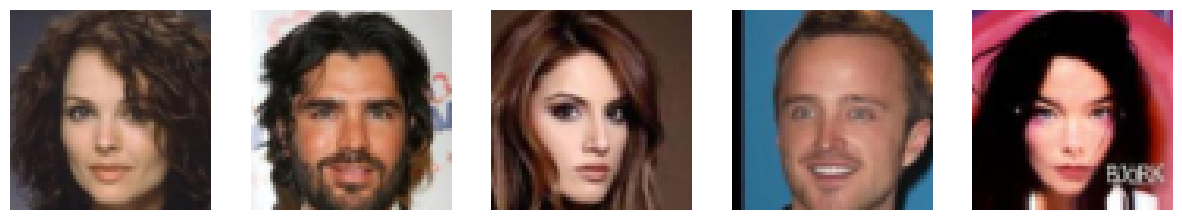

In [13]:
def sample_images(module, n=5):
    dataloader = module.test_dataloader()
    images, _ = next(iter(dataloader))

    sampled_images = images[:n]
    
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    for i in range(n):
        image = sampled_images[i]
        image = image.permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

sample_images(data, 5)

In [ ]:
model = vae_models['HVAE'](**config['HVAE']['model_params'])

In [ ]:
trainer = pl.Trainer(logger=tb_logger,
                         callbacks=[pl.callbacks.LearningRateMonitor(),
                                    pl.callbacks.EarlyStopping(monitor='val_loss',
                                                               patience=config['HVAE']['ES_patience'],
                                                               
                                    )],
                         **config['HVAE']['trainer_params'])

In [ ]:
train_schedule = VAExperiment(model, config['HVAE']['exp_params'])

In [ ]:
print(f"======= Training {config['HVAE']['model_params']['name']} =======")
trainer.fit(train_schedule, datamodule=data)